In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import dash
from dash import dcc, html
from dash.dash_table import DataTable, FormatTemplate
import dash_bootstrap_components as dbc

import plotly.express as px
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

###  ToDo:
* Wykres **NetWorth** to można zrobić coś w stylu, że jest interwał miesięczny, poczynając od miesiąca z daty pierwszej transakcji kupna etfa i potem już co miesiąc, gdzie po prostu biorę co miesiąc sumę wszytskich aktywów i przemnażam przez ich cenę z tego okresu (data końca miesiąca albo średnia miesięczna cena dla każdego tickera), co daje mi jedną obserwację na wykresie
    * z tego w sumie może powstać wykres gdzie jedna linia jest mnożona przez cenę i pokazuje realną zmienność portfela, a druga linia jest tylko wpłatami kapitału, czyli za ile coś kupiłem, to by fajnie pokazywało jaka jest relacja wpłacanego kapitału do realnej wartości portfela
    * można by też wtedy dodać kolory, że jak linia wartości jest wyżej niż wpłacania, to zysk - zielony, a jak spadnie poniżej wpłacony kapitał, to strata - czerwony
    * póki co jest tylko dla ETFów ale w domyśle powinno tu być wszystko z całej historii transakcji
* Wykres **Allocations** zrobić analogiczny do kołowych wykresów u mnie w excelu, ale z jakąś agregacją etfów z danego typu np. DTLA i IDTL wyświetlane jako jedna pozycja podpisana "US tre 20+". Dalsza granulacja na konta i poszczególne etfy może być w dalszym podsumowaniu (może osobne strony dla każdego brokera czy coś, chociaż nie wiem czy jest sens)
    * 2 analogiczne wykresy alokacji, gdzie jeden pokazuje stan faktyczny, a drugi domyślne proporcie
        * dodać do tego jakiś system alertów bazujących na kwotach transakcji, gdzie jeśli odchylenie np. etfa na akcje będzie większe od minimalnej opłacalnej kwoty rebalancingu, to żeby mi pokazywał alert "Wwaga, można dokonac efektywnego rebalancingu!"
    * aktualnie jest tylko dla ETF, w domyśle zrobić dla 4 głównych kategorii (bonds, etf_bond, etf_stock, pl_stocks)
* Dodać w zakładce **Holdings** kolumnę z info o koncie na jakim jest kupiony dany ticker
    * po dodaniu do dashboardu wszytskich aktywów w zakładce Holdings nadal nie będzie miejsca w zasadzie na nic poza ETFami
    * stworzyć dodatkowe tabele (może w jakichś osobnych specjalnych podstronach) gdzie będzie spis portfela obligacji skarbowych i akcji polskich
    * do tego na pewno wykres kołowy z proporcjami akcji w portfelu polskim
    * może też to^ ale z podziałem na branże
    * może wykres net worth ale tylko dla portfela akcji polskich
* Opracować system zapisywania dotychczasowych wyliczeń do jakiegoś pliku pickle, albo csv, żeby przy kazdym uruchomieniu nie było potrzeby przeliczania całej historii
    * coś w rodzaju, że:
        1. zanim zaczynam obliczenia sprawdzam czy istnieje plik z poprzednimi przeliczeniami
        2. wczytuje plik i sprawdzam jaka jest ostatnia data przeliczeń (ostatni miesiąc/kwartał)
        3. jeśli nie jest to aktualny okres, to tworzę listę okresów od ostatniego przeliczonego do daty dzisiejszej
        4. sprawdzam czy w pliku transactions.xlsx zdarzyły się jakieś dodatkowe transakcje w tym przedziale czasowym
            a. jeśli tak, to musi być cały algorytm doklejający możliwe nowe tickery itp, dużo roboty
            b. jeśli nie ide dalej
        5. przeliczam dla każdej daty wartości dla wykresów/tabel i doklejam do pliku z przeliczeniami
* Ogólna struktura:
    * belka z podsumowaniem
    * wiersz Composition i Allocation (bo to cały portfel)
    * potem wiersze dla poszczególnych rodzajów aktywów (Holdings i Wykres kapitał/zysk) z osobnymi podtytułami
        * ten co jest czyli ETFy
        * analogiczny do niego dla akcji polskich
        * wykresy kołowe proporcje akcji i proporcje branż
        * wiersz dla obligacji skarbowych

### Data loading

In [4]:
df_raw = pd.read_excel('data/transactions.xlsx')

In [5]:
df = df_raw.copy()

In [6]:
df_nw = df[df['asset_type'].str.contains('etf')].reset_index(drop=True)

### Functions

In [7]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [8]:
def holdings_table(tickers):
    holdings = pd.DataFrame(columns=['ticker', 'currency', 'asset_type', 'amount', 'avg_buy_price', 'current_price', 'return_pct'])
    for t in tickers:
        print(t)
        ticker = df[(df['ticker'] == t) & (df['transaction_type'] == 'buy')]
        ticker['total_cur'] = ticker['amount'] * ticker['price']
        ticker_agg = ticker[['ticker', 'currency', 'asset_type', 'amount', 'price']].groupby(['ticker', 'currency', 'asset_type']).sum().reset_index()
        ticker_agg.loc[0, 'price'] = ticker['total_cur'].sum() / ticker['amount'].sum() 
        ticker_agg = ticker_agg.rename(columns={'price': 'avg_buy_price'})
        ticker_agg['current_price'] = get_current_price(t)
        ticker_agg['return_pct'] = (ticker_agg['current_price'] - ticker_agg['avg_buy_price']) / ticker_agg['avg_buy_price']
        holdings = pd.concat([holdings, ticker_agg])
    holdings = holdings.reset_index(drop=True)
    holdings['avg_buy_price'] = holdings['avg_buy_price'].map("{:,.4f}".format).astype(float)
    holdings['current_price'] = holdings['current_price'].map("{:,.4f}".format).astype(float)
    holdings['return_pct'] = holdings['return_pct'] * 100
    holdings['return_pct'] = holdings['return_pct'].map('{:,.2f}%'.format)
    return holdings

In [9]:
def portfolio_return(holdings):
    current = (holdings['current_price'] * holdings['amount']).sum()
    initial = (holdings['avg_buy_price'] * holdings['amount']).sum()
    return round(((current - initial) / initial), 4)

In [73]:
def history_calculation(df_pivot):
    for i in range(1, len(df_pivot)):
        r = df_pivot.index[i]
        r1 = df_pivot.index[i-1]
        for c in df_pivot.columns:
            if df_pivot.loc[r, c] == 0:
                df_pivot.loc[r, c] = df_pivot.loc[r1, c]
            if df_pivot.loc[r, c] != df_pivot.loc[r1, c]:
                df_pivot.loc[r, c] = df_pivot.loc[r, c] + df_pivot.loc[r1, c]
    return df_pivot

In [74]:
import datetime

def last_day_of_month(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - datetime.timedelta(days=next_month.day)

In [75]:
def net_worth_plot_data(df):
    currencies = df[['ticker', 'currency']].drop_duplicates()
    df_group = df[['account', 'ticker', 'currency', 'asset_type', 'transaction_type', 'amount', 'price', 'commision', 'pln_exr', 'total_pln']]
    df_group['date_month'] = df['date'].astype(str).str[:7]
    
    df_pivot_capital_init = pd.pivot_table(df_group, values='total_pln', index='date_month', columns='ticker', aggfunc='sum', fill_value=0)
    df_pivot_amount = pd.pivot_table(df_group, values='amount', index='date_month', columns='ticker', aggfunc='sum', fill_value=0)

    df_pivot_capital_init = history_calculation(df_pivot_capital_init)
    df_pivot_amount = history_calculation(df_pivot_amount)
    
    start_dates = list(df_pivot_amount.index + str("-01"))

    end_dates = []

    for i in range(0, len(start_dates)):
        year = pd.to_datetime(start_dates)[i].year
        month = pd.to_datetime(start_dates)[i].month
        end_dates.append(str(last_day_of_month(datetime.date(year, month, 1))))
        
    for ticker in df_pivot_amount.columns:
        for i in range(0, len(start_dates)):
            if ticker == 'EIMI.L':
                avg_price = yf.download('EMIM.AS', start_dates[i], end_dates[i])['Close'].mean()
            else:
                avg_price = yf.download(ticker, start_dates[i], end_dates[i])['Close'].mean()
            amount = df_pivot_amount.loc[df_pivot_amount.index[i], ticker]
            if currencies[currencies['ticker'] == ticker]['currency'].reset_index(drop=True)[0] == 'USD':
                pln = yf.download('USDPLN=X', start_dates[i], end_dates[i])['Close'].mean()
            if (currencies[currencies['ticker'] == ticker]['currency'].reset_index(drop=True)[0] == 'EUR') | (ticker == 'EIMI.L'):
                pln = yf.download('EURPLN=X', start_dates[i], end_dates[i])['Close'].mean()
            df_pivot_amount.loc[df_pivot_amount.index[i], ticker] = amount * avg_price * pln
    
    df_plot = pd.concat([df_pivot_capital_init.sum(axis=1), df_pivot_amount.sum(axis=1)], axis=1)
    df_plot.columns = ['capital', 'asset_value']
    
    return df_plot

In [179]:
def holdings_value_to_pln(holdings_etfs):
    holdings = holdings_etfs.copy()
    holdings['current_value'] = round(holdings['amount'] * holdings['current_price'], 4)

    for row in holdings.index:
        if holdings.loc[row]['currency'] == 'USD':
            pln = get_current_price('USDPLN=X')
        if holdings.loc[row]['currency'] == 'EUR':
            pln = get_current_price('EURPLN=X')
        holdings.loc[row, 'current_value'] = holdings.loc[row]['current_value'] * pln
    return holdings

In [225]:
# nowe
def allocation_table(df, holdings_etfs, holdings_pl, target):
    holdings_etfs_pln = holdings_value_to_pln(holdings_etfs)
    holdings = holdings_pl.copy()
    holdings['current_value'] = holdings['amount'] * holdings['current_price']
    curr_hold_pl = holdings[['asset_type', 'current_value']].groupby('asset_type').sum().reset_index()
    curr_hold_etf = holdings_etfs_pln[['asset_type', 'current_value']].groupby('asset_type').sum().reset_index()
    curr_hold_bond = df[df['asset_type'] == 'bonds'].loc[:,['asset_type', 'total_pln']].groupby('asset_type').sum().reset_index()
    curr_hold_bond = curr_hold_bond.rename(columns={'total_pln': 'current_value'})
    pie_current = pd.concat([curr_hold_bond, curr_hold_etf, curr_hold_pl]).reset_index(drop=True)
    pie_current['current_value'] = pie_current['current_value'] / pie_current['current_value'].sum()
    pie_current['target_value'] = target
    pie_current['diff'] = pie_current['target_value'] - pie_current['current_value']
    return pie_current

In [242]:
def summary(df, holdings_etfs, holdings_pl):
    # amount
    bought_assets = df[df['transaction_type'] == 'buy']['ticker'].unique()
    sold_assets = df[df['transaction_type'] == 'sell']['ticker'].unique()
    all_amount = len(np.setdiff1d(bought_assets, sold_assets))

    # bonds
    bond_value = df[df['asset_type'] == 'bonds']['total_pln'].sum()

    # etfs
    holdings = holdings_value_to_pln(holdings_etfs)

    etfs_value = holdings['current_value'].sum()

    # stock pl
    pl_value = round(holdings_pl['amount'] * holdings_pl['current_price'], 4).sum()

    all_value = bond_value + etfs_value + pl_value

    total_return = (all_value - df['total_pln'].sum()) / df['total_pln'].sum()

    return pd.DataFrame({
        'Current Total Value': [str(round(all_value, 2)) + ' PLN'],
        'Amount of unique assets': [all_amount],
        'Total Return': [str(round(total_return, 4) * 100)[:4] + '%']
    })

### Composition by quarters

In [246]:
df_group = df[['account', 'ticker', 'asset_type', 'amount','total_pln']]

df_group['quarter'] = df['date'].dt.year.astype(str) + "Q" + df['date'].dt.quarter.astype(str)

df_pivot = pd.pivot_table(df_group, values='total_pln', index='quarter', columns='asset_type', aggfunc='sum', fill_value=0)

for i in range(1, len(df_pivot)):
    r = df_pivot.index[i]
    # print(r)
    r1 = df_pivot.index[i-1]
    for c in df_pivot.columns:
        if df_pivot.loc[r, c] == 0:
            df_pivot.loc[r, c] = df_pivot.loc[r1, c]
        if df_pivot.loc[r, c] != df_pivot.loc[r1, c]:
            df_pivot.loc[r, c] = df_pivot.loc[r, c] + df_pivot.loc[r1, c]

df_prc = df_pivot.div(df_pivot.sum(axis=1), axis=0).reset_index()

df_plot = pd.melt(df_prc, id_vars='quarter', value_vars=list(df_prc.columns[1:]), var_name='asset_type', value_name='total_pln')

In [248]:
df_plot.to_pickle('data/df_plot.pkl')

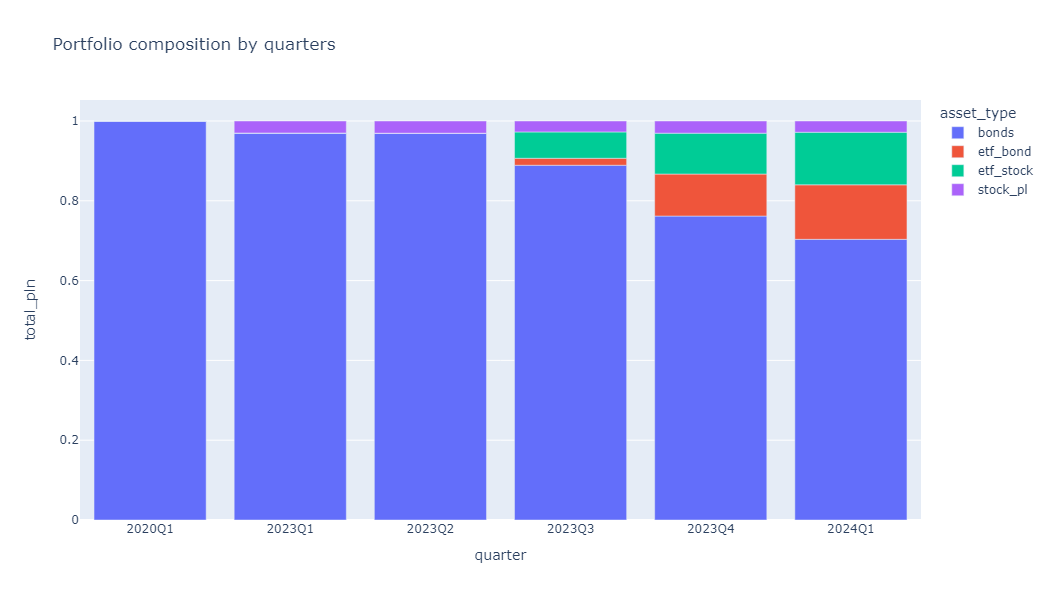

In [107]:
fig = px.bar(df_plot, x="quarter", y="total_pln", color="asset_type", title="Portfolio composition by quarters")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    # paper_bgcolor="LightSteelBlue",
)

fig.show()

### Holdings table

In [157]:
holdings_etfs = holdings_table(df_nw['ticker'].unique())

EIMI.L
DTLA.L
SWRD.L
IDTL.L
VWRL.AS


In [12]:
holdings_etfs.to_pickle('data/holdings_etfs.pkl')

In [252]:
print("ETF portfolio return: ", portfolio_return(holdings_etfs))

ETF portfolio return:  0.056


In [249]:
# woodpecker nie jest na zagranicznych listach, więc nie ma tickera
bought_pl = df[df['asset_type'].str.contains('pl')]['ticker'].unique()
sold_pl = df[(df['asset_type'].str.contains('pl')) & (df['transaction_type'] == 'sell')]['ticker'].unique()
holdings_pl = holdings_table(np.setdiff1d(bought_pl, np.append(sold_pl, 'WPR.WA')))

1AT.WA
ALL.WA
APR.WA
ASE.WA
BCS.WA
CDR.WA
VOT.WA
WTN.WA


In [250]:
holdings_pl.to_pickle('data/holdings_pl.pkl')

In [251]:
print("PL portfolio return: ", portfolio_return(holdings_pl))

PL portfolio return:  0.0774


### Net Worth Table

In [91]:
# tymczasowo ograniczam się do ETFów
df_nw = df[df['asset_type'].str.contains('etf')].reset_index(drop=True)

In [92]:
df_nw_plot = net_worth_plot_data(df_nw).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [93]:
df_nw_plot['asset_value'] = df_nw_plot['asset_value'] - df_nw_plot['capital']

In [94]:
df_nw_plot = pd.melt(df_nw_plot, id_vars='date_month', value_vars=list(df_nw_plot.columns[1:]), var_name='class', value_name='value_pln')

In [110]:
df_nw_plot.to_pickle('data/df_nw_plot.pkl')

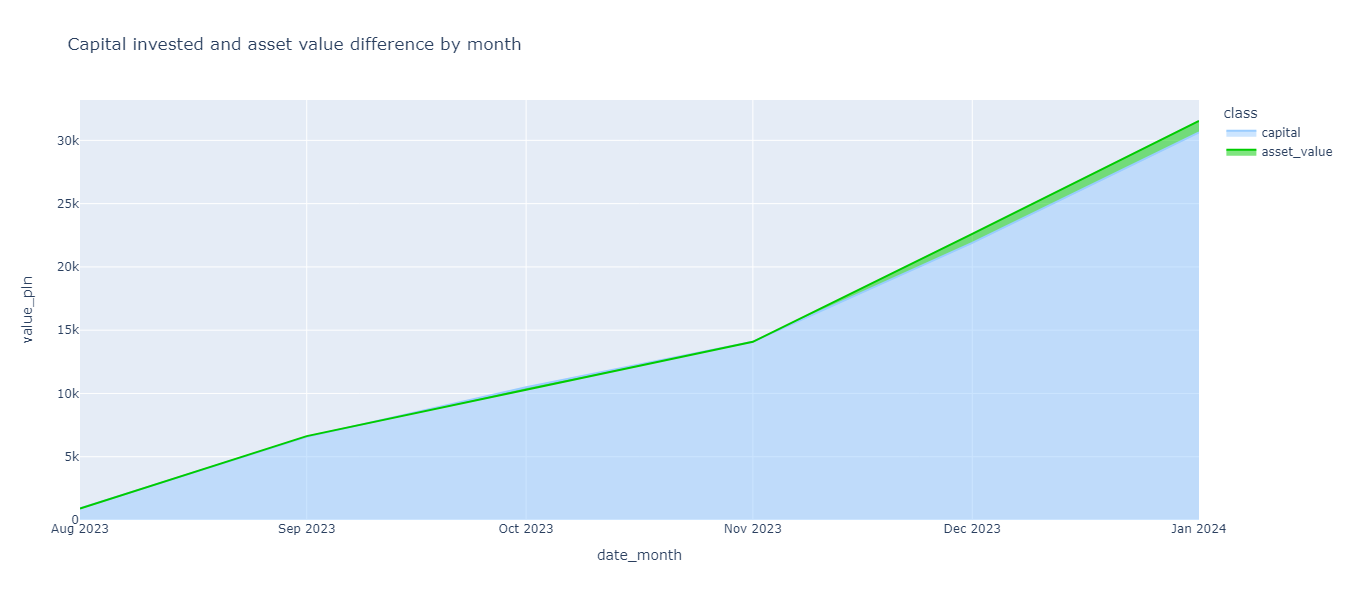

In [225]:
# jesli chcialbym kiedys sie pobawic w kolory to tu: https://community.plotly.com/t/it-is-possible-to-fill-area-with-different-colors-on-a-line-plot/31664/8

fig = px.area(df_nw_plot, 
              x="date_month", 
              y="value_pln", 
              color='class', 
              line_group='class', 
              title="Capital invested and asset value difference by month",
              color_discrete_sequence=["#99ccff", "#00cc00"]
             )

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    # paper_bgcolor="LightSteelBlue",
)

fig.show()

### Pie charts

In [226]:
pie_current = allocation_table(df, holdings_etfs, holdings_pl, [0.35, 0.2, 0.40, 0.05])

In [229]:
pie_current.to_pickle('data/pie_current.pkl')

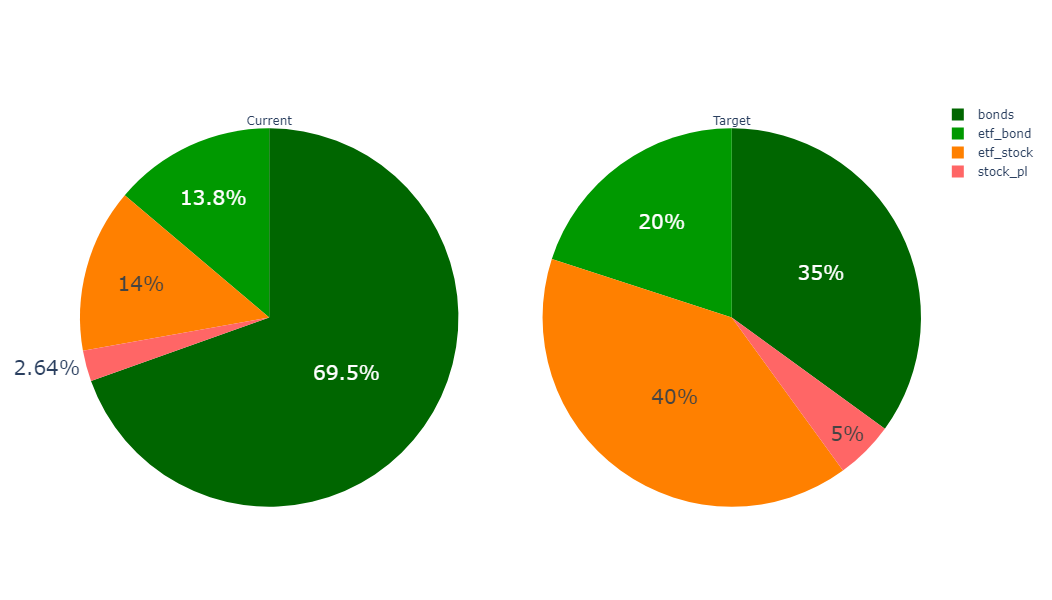

Portfolio needs rebalancing!
Change the amount of bonds by 0.06174966743679752
Change the amount of stocks by 0.2600880149532527


In [224]:
# dodać info ile te procenty rebalancingu to jest sztuk danego aktywa po aktualnej cenie (z racji, że kilka aktywów to po średniej ważonej cenie albo po cenie tego z ike)
# może w ogóle dodac kominukat "aby optymalnie dokonać rebalancingu dokup X sztuk tickera XXXX.XX po aktualnej cenie X"

trace1 = go.Pie(
    values=pie_current['current_value'],
    labels=pie_current['asset_type'],
    domain=dict(x=[0, 0.45]),
    name="Current",
    title="Current",
    hoverinfo="label+percent+name",
    sort=False
)
trace2 = go.Pie(
    values=pie_current['target_value'],
    labels=pie_current['asset_type'],
    domain=dict(x=[0.55, 1.0]),
    name="Target",
    title="Target",
    hoverinfo="label+percent+name",
    sort=False
)
layout = go.Layout()
data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
fig.update_traces(marker=dict(colors=["#006600", "#009900", "#ff8000", "#ff6666"]), textfont_size=20)
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
)
fig.show()
print("Portfolio needs rebalancing!")
print("Change the amount of bonds by", pie_current[pie_current['asset_type'] == 'etf_bond']['diff'].reset_index(drop=True)[0])
print("Change the amount of stocks by", pie_current[pie_current['asset_type'] == 'etf_stock']['diff'].reset_index(drop=True)[0])

### Banner

In [243]:
summary_table = summary(df, holdings_etfs, holdings_pl)

In [245]:
summary_table.to_pickle('data/summary.pkl')

### Dashboard 

In [287]:
df_plot = pd.read_pickle('data/df_plot.pkl')
df_nw_plot = pd.read_pickle('data/df_nw_plot.pkl')
holdings_etfs = pd.read_pickle('data/holdings_etfs.pkl')
holdings_pl = pd.read_pickle('data/holdings_pl.pkl')
pie_current = pd.read_pickle('data/pie_current.pkl')
summary = pd.read_pickle('data/summary.pkl')

In [288]:
# Create a Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP, '/assets/styles.css'])

app.layout = html.Div([
    
    dbc.Row([
        dbc.Col([
            html.H1("Investment Portfolio Dashboard", id='title'),
        ]),
        dbc.Col([
            html.Div([
                DataTable(
                    id='summary-table',
                    columns=[{'name': col, 'id': col} for col in summary.columns],
                    data=summary.to_dict('records'),
                    style_as_list_view=True,
                    style_cell={'padding': '1px', 'fontSize': 16},
                    style_header={
                        'backgroundColor': 'white',
                        'fontWeight': 'bold'
                    },
                    style_table={'width': '100%'},
                ),
            ]),
        ])
    ], id='main-row'),
    
    dbc.Row([
        dbc.Col([
            html.Div([
                html.H2("Portfolio composition by quarters"),
                dcc.Graph(
                    id='bar-chart',
                    figure=px.bar(
                        df_plot,
                        x="quarter",
                        y="total_pln",
                        color='asset_type',
                        color_discrete_sequence=["#006600", "#009900", "#ff8000", "#ff6666"]
                    ).update_layout(
                        yaxis={'title': None},
                        xaxis={'title': None},
                        autosize=True,
                        font=dict(size=11),
                        legend_title_text='',
                        legend=dict(
                            orientation="h",
                            entrywidth=50,
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=1
                        )
                    )
                )
            ], className="blobs")
        ]),
        dbc.Col([
            html.Div([
                html.H2("Asset allocation"),
                dcc.Graph(
                    id='pie-chart',
                    figure=go.Figure(
                        data=[
                            go.Pie(
                                values=pie_current['current_value'],
                                labels=pie_current['asset_type'],
                                domain=dict(x=[0, 0.49]),
                                name="Current",
                                title="Current",
                                hoverinfo="label+percent+name",
                                sort=False
                            ),
                            go.Pie(
                                values=pie_current['target_value'],
                                labels=pie_current['asset_type'],
                                domain=dict(x=[0.51, 1.0]),
                                name="Target",
                                title="Target",
                                hoverinfo="label+percent+name",
                                sort=False
                            )
                        ],
                        layout=go.Layout()
                    ).update_traces(
                        marker=dict(colors=["#006600", "#009900", "#ff8000", "#ff6666"]), 
                        textfont_size=11,
                    ).update_layout(
                        autosize=True,
                        font=dict(size=11),
                        legend=dict(
                            orientation="h",
                            entrywidth=50,
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=1
                        )
                    ),
                ),
            ], className="blobs"),
        ])
    ]),
    # ETF
    dbc.Row([
        html.H1("ETFs"),
        dbc.Col([
            html.Div([
                html.H2("Holdings", style={'margin-bottom': '70px'}),
                DataTable(
                    id='etf-table',
                    columns=[{'name': col, 'id': col} for col in holdings_etfs.columns],
                    data=holdings_etfs.to_dict('records'),
                    style_as_list_view=True,
                    style_cell={'padding': '5px', 'fontSize': 13},
                    style_header={
                        'backgroundColor': 'white',
                        'fontWeight': 'bold'
                    },
                    style_table={'width': '100%'},
                ),
            ], className="blobs"),
        ]),

        dbc.Col([
            html.Div([
                html.H2("Value by month"),
                dcc.Graph(
                    id='etf-area-chart',
                    figure=px.area(
                        df_nw_plot,
                        x="date_month",
                        y="value_pln",
                        color='class',
                        line_group='class',
                        color_discrete_sequence=["#99ccff", "#00cc00"]
                    ).update_layout(
                        yaxis={'title': None},
                        xaxis={'title': None},
                        autosize=True,
                        legend_title_text='',
                        font=dict(size=11),
                        legend=dict(
                            orientation="h",
                            entrywidth=110,
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=1
                        )
                    )
                ),
            ], className="blobs"),
        ])
    ]),
    # Stocks
    dbc.Row([
        html.H1("Stocks"),
        dbc.Col([
            html.Div([
                html.H2("Holdings", style={'margin-bottom': '70px'}),
                DataTable(
                    id='stocks-table',
                    columns=[{'name': col, 'id': col} for col in holdings_pl.columns],
                    data=holdings_pl.to_dict('records'),
                    style_as_list_view=True,
                    style_cell={'padding': '5px', 'fontSize': 13},
                    style_header={
                        'backgroundColor': 'white',
                        'fontWeight': 'bold'
                    },
                    style_table={'width': '100%'},
                ),
            ], className="blobs"),
        ]),

        dbc.Col([
            html.Div([
                html.H2("Capital invested and asset value difference by month"),
                dcc.Graph(
                    id='stocks-area-chart',
                    figure=px.area(
                        df_nw_plot,
                        x="date_month",
                        y="value_pln",
                        color='class',
                        line_group='class',
                        color_discrete_sequence=["#99ccff", "#00cc00"]
                    ).update_layout(
                        yaxis={'title': None},
                        xaxis={'title': None},
                        autosize=True,
                        legend_title_text='',
                        font=dict(size=11),
                        legend=dict(
                            orientation="h",
                            entrywidth=110,
                            yanchor="bottom",
                            y=1.02,
                            xanchor="right",
                            x=1
                        )
                    )
                ),
            ], className="blobs"),
        ])
    ]),
    
], id="main-div")


# Run the app
if __name__ == '__main__':
    app.run_server(jupyter_mode='external')


Dash app running on http://127.0.0.1:8050/
